# Прогнозирование электропотребления

## Постновка задачи

<p> В файле data_train.csv предоставлены почасовые данные потребления электроэнергии одного из предприятий (c 1.01.2019 по 8.09.2019). </p> <p> Необходимо построить почасовой прогноз потребления с 9.09.2019 по 22.09.2019. В качестве метрики используется RMSE. </p>

## Предобработка данных

Удостоверимся, что данные корректны и обработаем признаки, если необходимо

Подключаем необходимые библиотеки

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error

import statsmodels.api as sm
import statsmodels.tsa.api as smt
from sklearn.metrics import mean_squared_error

import fbprophet
from fbprophet import Prophet

Импортируем предоставленные данные методом read_csv() в переменную df, выводим общую информацию методом info(), выведем 5 случайных строк методом sample()

In [2]:
df = pd.read_csv('/Users/zlatakoniseva/data_train.csv', index_col = [0], parse_dates = [0])
df.info()
df.sample(10, random_state = 12345)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6024 entries, 2019-01-01 00:00:00 to 2019-09-08 23:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   fact    6024 non-null   float64
dtypes: float64(1)
memory usage: 94.1 KB


,fact
timestamp,
2019-04-25 10:00:00,746.0
2019-01-28 17:00:00,747.0
2019-08-18 18:00:00,245.0
2019-06-16 12:00:00,269.0
2019-03-04 02:00:00,345.0
2019-01-25 09:00:00,841.0
2019-03-10 17:00:00,348.0
2019-03-20 13:00:00,699.0
2019-02-17 05:00:00,356.0


Выведем общую информацию признака fact методом describe()

In [3]:
df.fact.describe()

count    6024.000000
mean      511.303121
std       175.707942
min       158.000000
25%       356.000000
50%       503.000000
75%       654.000000
max      1015.000000
Name: fact, dtype: float64

Проверим, располагаются ли данные в хронологическом порядке методом is_monotonic

In [4]:
print(df.index.is_monotonic)

True


### Вывод

- данные были импортированны методом read_csv() в переменную df
- были получена общая информация о данных методами info(), describe() и is_monotonic, по полученным данным можно сделать вывод, что данные не содержат пропусков, имеют адекватные значения, располагаются в хронологическом порядке
 
Таким образом можно сделать вывод, что данные корректны и готовы к дальнейшей обработке

## Анализ

Для начала взглянем на данные, а также на коррелограммы ACF и PACF для нахождения колличества значимых лагов.  
Также найдем критерий Дики-Фуллера, для проверки ряда на стационарность.

Функция вывода графиков

Критерий Дики-Фуллера: p-value = 0.000000


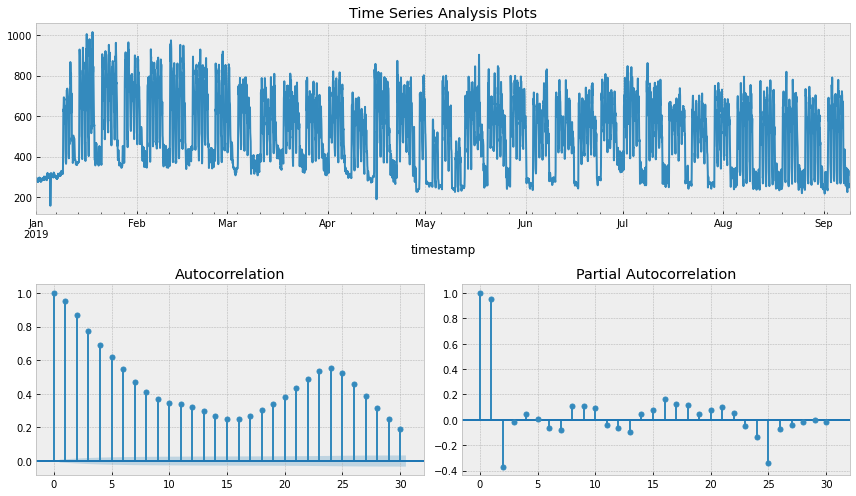

In [5]:
def plot_build(y, lags = None, figsize = (12, 7), style = 'bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize = figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan = 2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax = ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags = lags, ax = acf_ax, alpha = 0.5)
        smt.graphics.plot_pacf(y, lags = lags, ax = pacf_ax, alpha = 0.5)

        print("Критерий Дики-Фуллера: p-value = %f" % sm.tsa.stattools.adfuller(y)[1])

        plt.tight_layout()
    return 

plot_build(df['fact'], lags = 30)

По полученым результатам можно сделать следующие выводы:
- p-value = 0.000000 можно сделать вывод, что нулевая гипотеза о том, что ряд нестационарный отвергается  
- в первом графике заметна ярко выраженная сезонность, а именно недельная: видны явные спады потребления энергии по выходным и периоды государственных праздников (например, в самом начале рост энергии происходит сразу после 10-го января)
- коррелограммам ACF и PACF говорят о наличии большого колличества значимых лагов

Таким образом, для дальнейшей корректной работы модели, данные нуждаются в преобразовании, чтоб избавиться от большого колличества значимых лагов, возьмем первые разности и снова выведем графики

In [6]:
df['fact_season'] = df.fact - df.fact.shift(24*7)

In [7]:
df['fact_diff'] = df.fact_season - df.fact_season.shift(1)

Критерий Дики-Фуллера: p-value = 0.000000


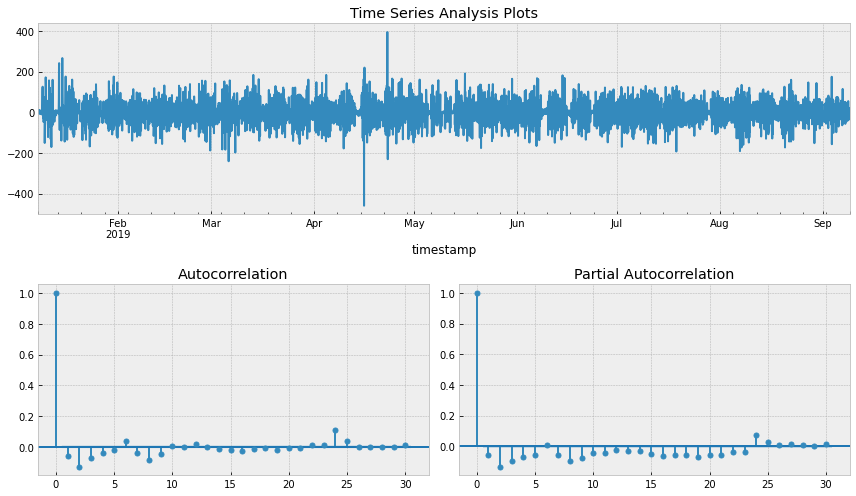

In [8]:
plot_build(df.fact_diff[24 * 7 + 1 :], lags = 30)

Теперь значимых лагов нет и данные подготовленны к работе моделей

### Вывод

Были выведенны данные, а также на коррелограммы ACF и PACF для нахождения колличества значимых лагов. Также был проверен критерий Дики-Фуллера, для проверки ряда на стационарность. 

По полученым результатам можно сделать следующие выводы:
- p-value = 0.000000 можно сделать вывод, что нулевая гипотеза о том, что ряд нестационарный отвергается 
- в первом графике заметна ярко выраженная сезонность, а именно недельная: видны явные спады потребления энергии по выходным и периоды государственных праздников (например, в самом начале рост энергии происходит сразу после 10-го января)
- коррелограммам ACF и PACF говорят о наличии большого колличества значимых лагов

Для дальнейшей корректной работы модели были взяты первые разности. Для проверки были снова выведенны графики преобразованных данных, по которым можно заключить, что данные корректны и подготовленны к работе моделей

## Построение моделей

В данном проекте будет рассмотриваться две модели: SARIMAX и fbprophet, на основе их работы на тренировачных данных будет выбрана модель для предсказания

### SARIMAX

Инициируем модель

In [9]:
model = sm.tsa.statespace.SARIMAX(df.fact, order = (1, 1, 1), seasonal_order = (0, 1, 0, 24 * 7)).fit(disp = -1)
print(model.summary())

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


                                      SARIMAX Results                                       
Dep. Variable:                                 fact   No. Observations:                 6024
Model:             SARIMAX(1, 1, 1)x(0, 1, [], 168)   Log Likelihood              -31174.068
Date:                              Sun, 13 Mar 2022   AIC                          62354.135
Time:                                      18:06:54   BIC                          62374.161
Sample:                                  01-01-2019   HQIC                         62361.098
                                       - 09-08-2019                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8207      0.008     97.880      0.000       0.804       0.837
ma.L1         -0.97

Выведем графики остатков работы модели

Критерий Дики-Фуллера: p-value = 0.000000


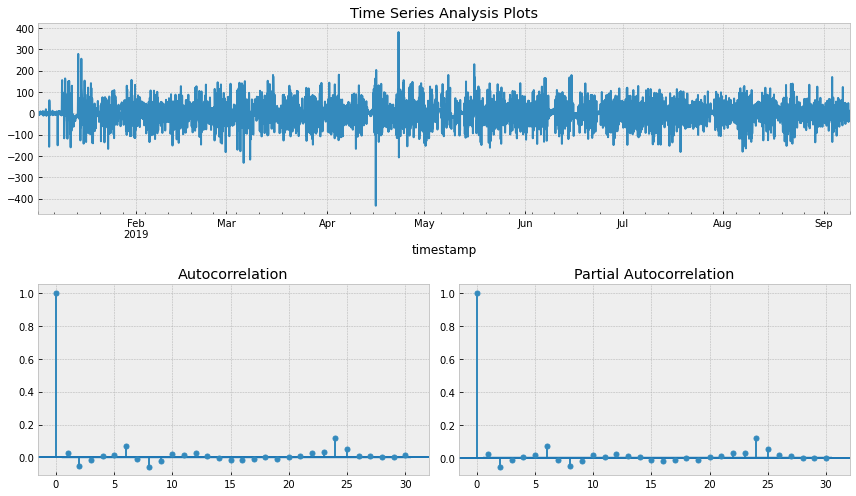

In [10]:
plot_build(model.resid[24 :], lags = 30)

По полученым результатам можно сделать следующие выводы:
- p-value = 0.000000 можно сделать вывод, что нулевая гипотеза о том, что ряд нестационарный отвергается 
- коррелограммам ACF и PACF выглядят корректно

Построим прогноз и нарисуем график

In [11]:
df['arima_model'] = model.fittedvalues

In [12]:
forecast = model.predict(start = df.shape[0], end = df.shape[0] + 335)
arima_forecast = forecast # запоминаем презсказания SARIMAX

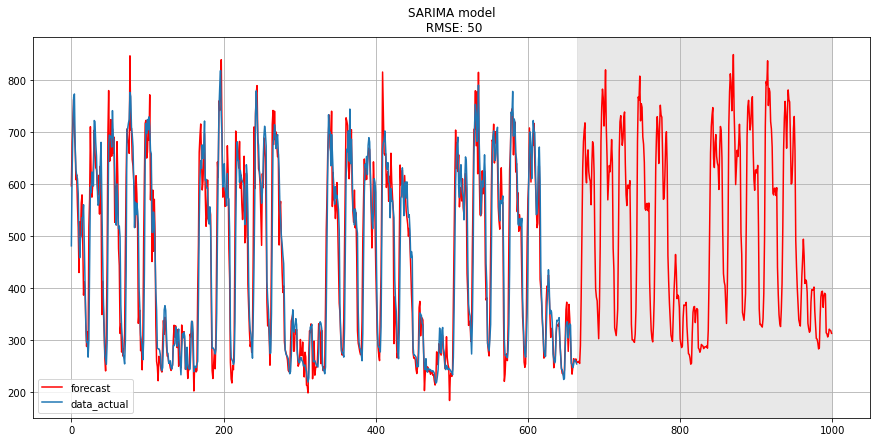

In [13]:
forecast = df.arima_model.append(forecast).values[-1000 : ]
data_actual = df.fact.values[-665 : ]

plt.figure(figsize = (15, 7))
plt.plot(forecast, color = 'r', label = 'forecast')
plt.title('SARIMA model\n RMSE: {}'.format(round(mean_squared_error(df.dropna().fact, df.dropna().arima_model) ** 0.5)))
plt.plot(data_actual, label = 'data_actual')
plt.legend()
plt.axvspan(len(data_actual), len(forecast), alpha = 0.5, color = 'lightgrey')
plt.grid(True)

В результате получили RMSE = 50

#### Вывод

Была построена модель SARIMAX со следующими гиперпараметрами:
- p = 1
- d = 1
- q = 1
- P = 0
- D = 1
- Q = 0
- s = 24 * 7

Были проверены остатки работы модели: был получен критерий Дики-Фуллера и выведены коррелограммамы ACF и PACF.  
По полученым результатам можно сделать следующие выводы:
- p-value = 0.000000 можно сделать вывод, что нулевая гипотеза о том, что ряд нестационарный отвергается 
- коррелограммам ACF и PACF выглядят корректно

В результате работы модели был получен прогноз, ошибка на уже имеющихся данных составила RMSE = 50, что говорит о достаточно хорошей работе модели

### FBprophet

Инициируем модель и преобразуем столбцы для корректной работы

In [14]:
df['data_col'] = df.index

In [15]:
temp = df.rename(columns = {'data_col': 'ds', 'fact': 'y'})

In [16]:
temp_prophet = fbprophet.Prophet(changepoint_prior_scale=0.5)
temp_prophet.fit(temp)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Построим прогноз и нарисуем график

In [17]:
temp_forecast = temp_prophet.make_future_dataframe(periods = 24 * 7 * 2, freq = 'H')# Make predictions
temp_forecast = temp_prophet.predict(temp_forecast)

In [18]:
df['fb_model'] = list(temp_forecast.yhat.iloc[:6024,])

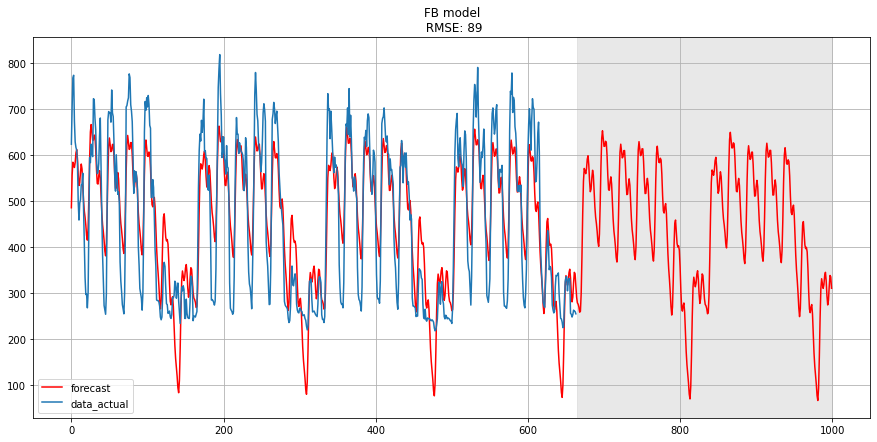

In [19]:
forecast = temp_forecast['yhat'].values[-1000 : ]
data_actual = df.fact.values[-664 : ]

plt.figure(figsize = (15, 7))
plt.plot(forecast, color = 'r', label = 'forecast')
plt.title("FB model\n RMSE: {}".format(round(mean_squared_error(df.dropna().fact, df.dropna().fb_model) ** 0.5)))
plt.plot(data_actual, label = 'data_actual')
plt.legend()
plt.axvspan(len(data_actual), len(forecast), alpha = 0.5, color = 'lightgrey')
plt.grid(True)

В результате получили RMSE = 89

#### Вывод

Данные были преобразованы, для корректной работы модели. В результате работы модели был получен прогноз, ошибка на уже имеющихся данных составила RMSE = 89

### Вывод

Были протестированны на исходных данных 2 модели, значение RSME на каждой составило: 
- SARIMAX: RMSE = 50
- fbprophet: RMSE = 89

В результате можно заключить, что модель SARIMAX показала себя в значительной мере лучше и именно предсказания этой модели стоит использовать для работы

## Результат

Выгружаем предсказания модели SARIMA в csv-файл predicted.csv методом to_csv()

In [20]:
arima_forecast.to_frame().to_csv('predicted.csv')

## Общий вывод

В данном проекте была поставленна следующая цель: построить почасовой прогноз потребления с 9.09.2019 по 22.09.2019

Для получения наиболее точного прогноза необходимо было оченить качество нескольких моделей и провести анализ данных

Работа над проектов происходила в несколько этапов:

**Предобработка данных**

- данные были импортированны методом read_csv() в переменную df
- были получена общая информация о данных методами info(), describe() и is_monotonic, по полученным данным можно сделать вывод, что данные не содержат пропусков, имеют адекватные значения, располагаются в хронологическом порядке
 
Таким образом можно сделать вывод, что данные корректны и готовы к дальнейшей обработке

**Анализ**

Были выведенны данные, а также на коррелограммы ACF и PACF для нахождения колличества значимых лагов. Также был проверен критерий Дики-Фуллера, для проверки ряда на стационарность. 

По полученым результатам можно сделать следующие выводы:
- p-value = 0.000000 можно сделать вывод, что нулевая гипотеза о том, что ряд нестационарный отвергается 
- в первом графике заметна ярко выраженная сезонность, а именно недельная: видны явные спады потребления энергии по выходным и периоды государственных праздников (например, в самом начале рост энергии происходит сразу после 10-го января)
- коррелограммам ACF и PACF говорят о наличии большого колличества значимых лагов

Для дальнейшей корректной работы модели были взяты первые разности. Для проверки были снова выведенны графики преобразованных данных, по которым можно заключить, что данные корректны и подготовленны к работе моделей

**Построение моделей**

Были протестированны на исходных данных 2 модели, значение RSME на каждой составило: 
- SARIMAX: RMSE = 50
- fbprophet: RMSE = 89

В результате можно заключить, что модель SARIMAX показала себя в значительной мере лучше и именно предсказания этой модели стоит использовать для работы, что мы и делаем

**Результат**

В результате используем модель SARIMAX для предсказания почасового прогноза потребления энергии с 9.09.2019 по 22.09.2019. Выгружаем предсказания в csv-файл методом to_csv()

Таким образом цель проекта выполненна